# Cutmix

In [23]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [24]:
import os
import gc
import random
import math
import pathlib
import warnings

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn import metrics
from sklearn import model_selection

import tensorflow as tf
import tensorflow.keras.backend as K
import tensorflow_addons as tfa

import albumentations as A

In [25]:
warnings.simplefilter("ignore")
pd.set_option("display.max_columns", None)
print("Tensorflow version =", tf.__version__)

Tensorflow version = 2.3.0


## Configs

### Initialize Environment

In [26]:
# CONFIGURE GPUs
gpus = tf.config.list_physical_devices("GPU"); print(gpus)
if len(gpus) == 1: strategy = tf.distribute.OneDeviceStrategy(device="/gpu:0")
else: strategy = tf.distribute.MirroredStrategy()

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [27]:
# ENABLE MIXED PRECISION for speed
tf.config.optimizer.set_experimental_options({"auto_mixed_precision": True})
print("Mixed precision enabled")

Mixed precision enabled


### Data and Logs

In [28]:
DATA_PATH = pathlib.Path("../input")
MODEL_PATH = pathlib.Path("../models")
LOG_PATH = pathlib.Path("../logs")

In [29]:
BATCH_SIZE = 64
EPOCHS = 100
DIM = 28
SEED = 42
N_CLASSES = 26
LETTER_LABEL_MAP = {c: i for i, c in enumerate("ABCDEFGHIJKLMNOPQRSTUVWXYZ")}

MEAN = 0.143
STD = 0.254

In [30]:
def seed_everything(seed):
    os.environ["PYTHONHASHSEED"] = str(seed)
    random.seed(seed)
    np.random.seed(seed)
    tf.random.set_seed(seed)

seed_everything(SEED)

In [31]:
# # VERSION MAJOR and MINOR for logging
# mm = 1; rr = 0

# # BEGIN LOG FILE
# with open(LOG_PATH/f"log-{mm}-{rr}.txt", "a") as f:
#     print(f"Logging to log-{mm}-{rr}.txt")
#     f.write("#############################\n")
#     f.write(f"Trial mm={mm}, rr={rr}\n")
#     f.write("baseline, batch_size=64, seed=42, 28x28, fold=all, LR 1e-3 with 0.75 decay\n")
#     f.write("#############################\n")

## STEP 1: Preprocess

In [32]:
train = pd.read_csv(DATA_PATH / "train.csv")
x_train = train.drop(["id", "digit", "letter"], axis=1).values
x_train = x_train.reshape((-1, DIM, DIM, 1))
x_train = x_train / 255.
x_train = (x_train - MEAN) / STD
print("Train shape", x_train.shape)

Train shape (2048, 28, 28, 1)


In [33]:
# y_train = train.digit.values
y_train = train.letter.map(LETTER_LABEL_MAP).values
digits = train.digit.values
letters = train.letter.values

### EDA

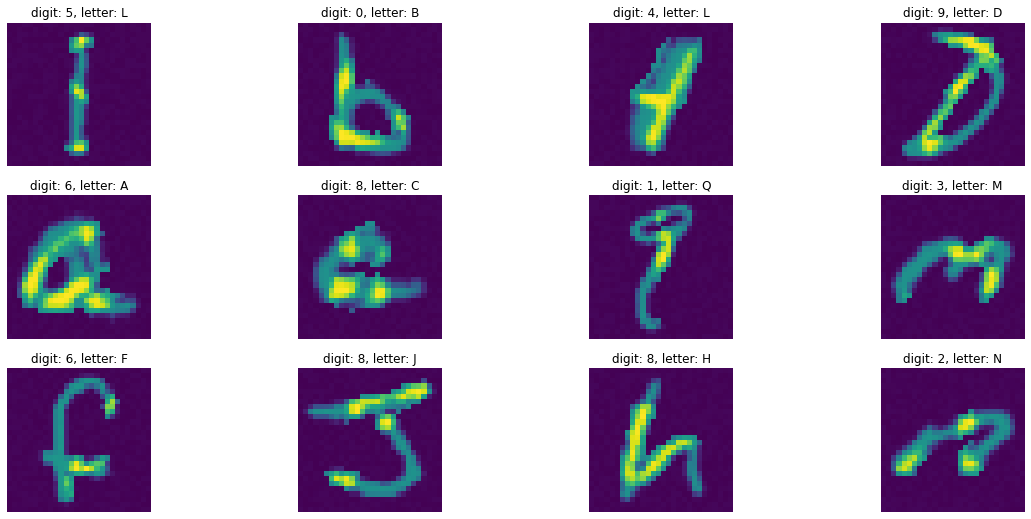

In [34]:
rows = 3; cols = 4
fig, axes = plt.subplots(rows, cols, figsize=(20, (rows/cols)*12))
axes = axes.flatten()
for i, ax in enumerate(axes):
    ax.imshow(x_train[i,:,:,0])
    ax.set_title(f"digit: {digits[i]}, letter: {letters[i]}")
    ax.axis("off")
plt.show()

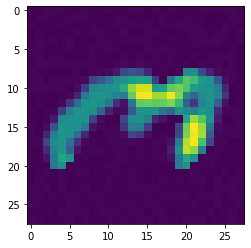

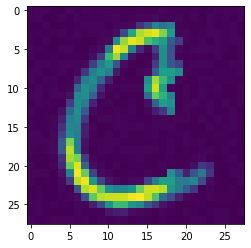

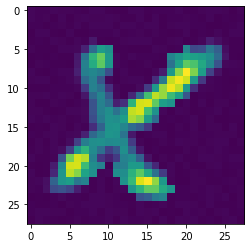

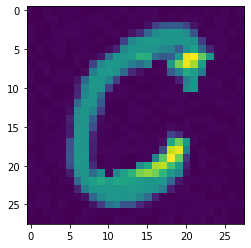

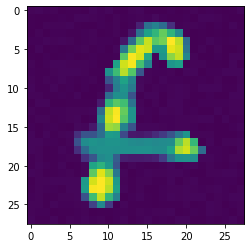

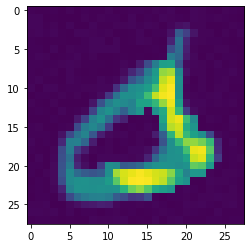

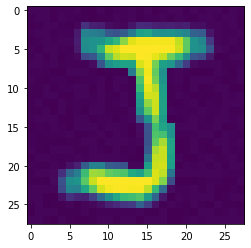

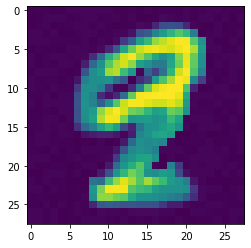

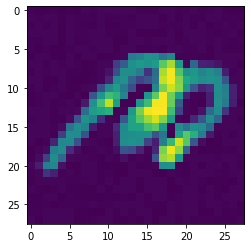

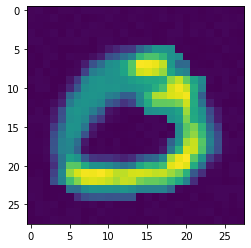

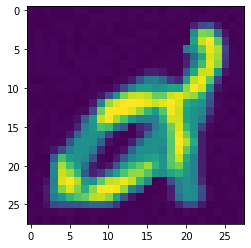

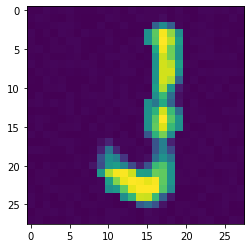

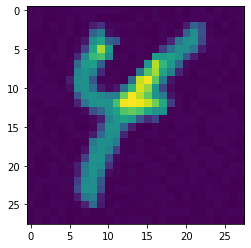

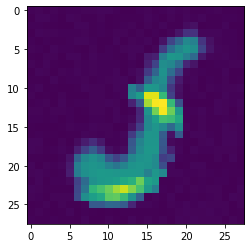

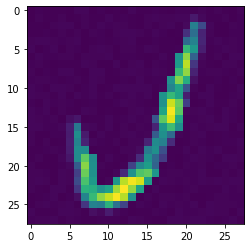

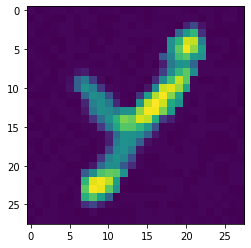

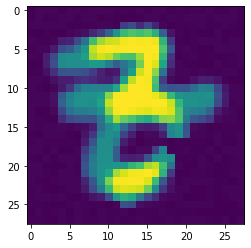

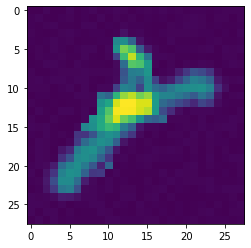

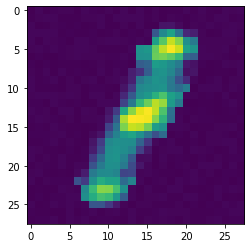

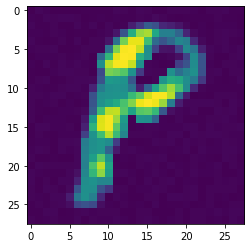

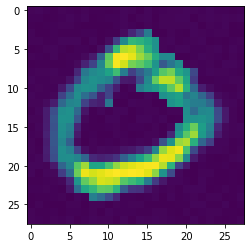

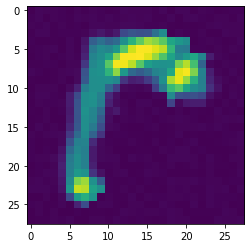

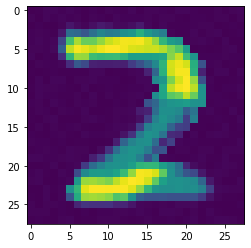

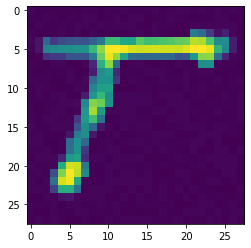

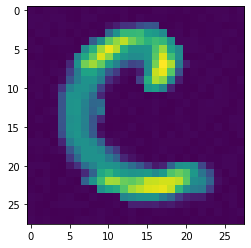

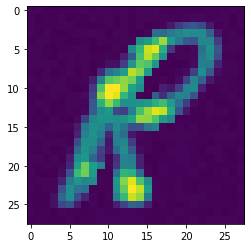

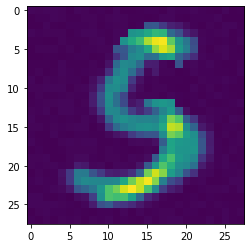

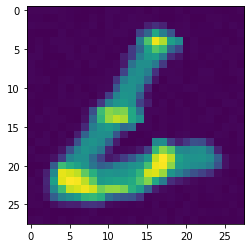

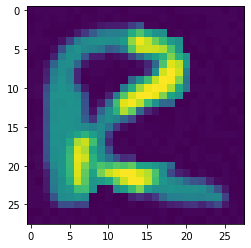

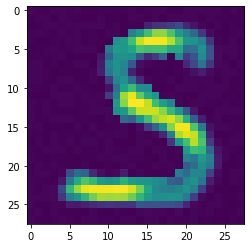

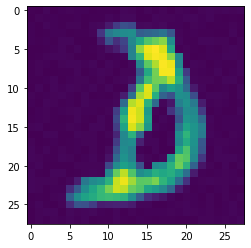

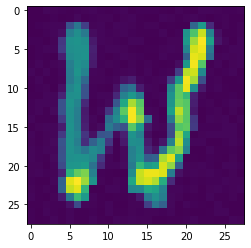

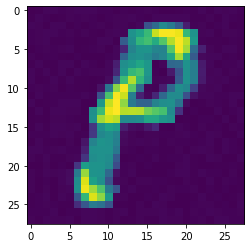

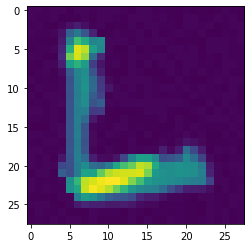

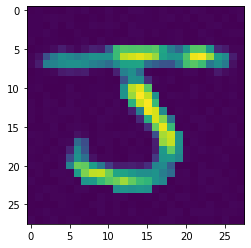

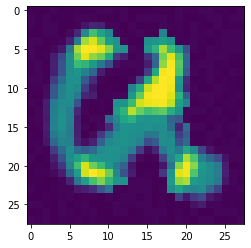

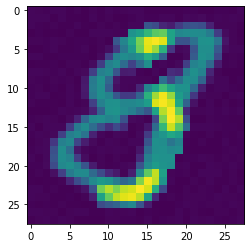

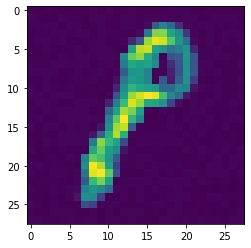

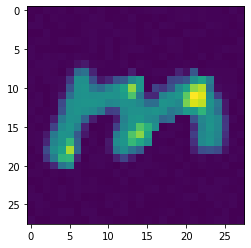

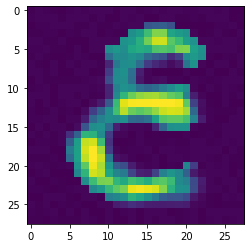

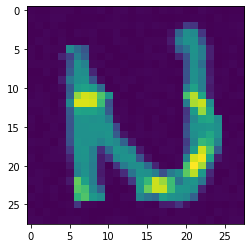

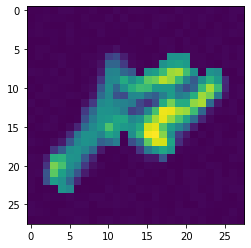

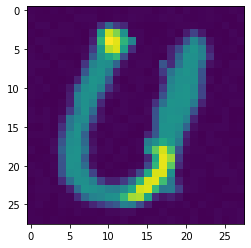

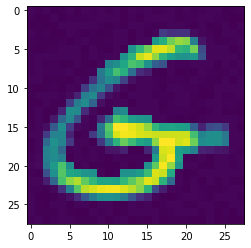

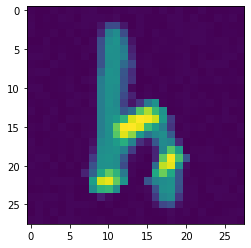

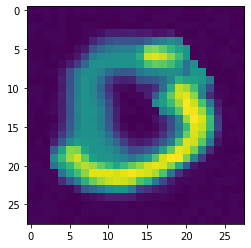

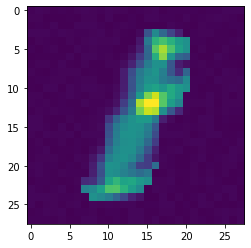

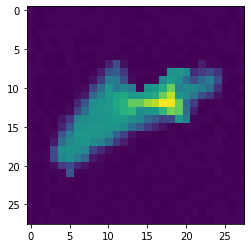

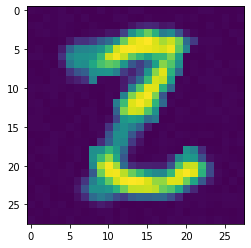

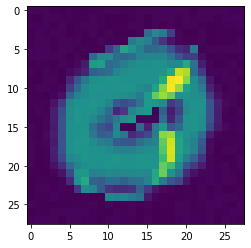

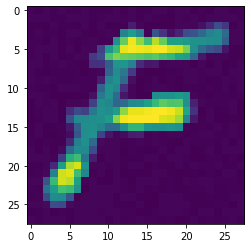

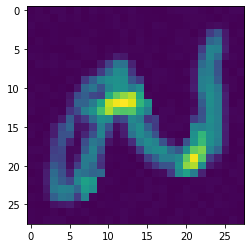

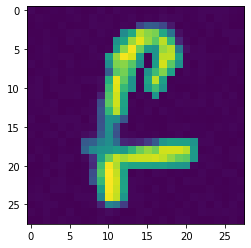

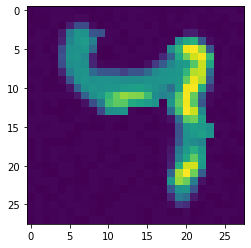

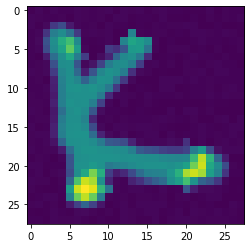

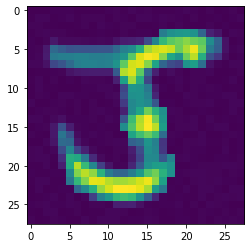

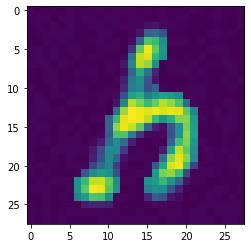

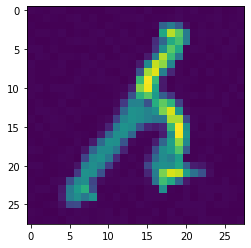

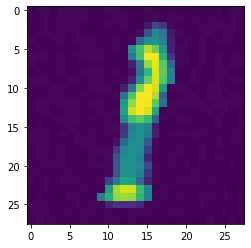

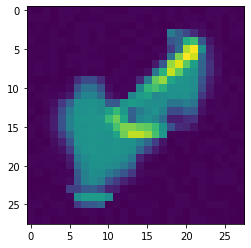

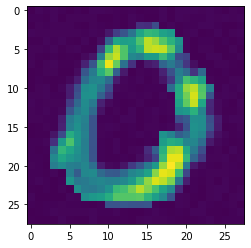

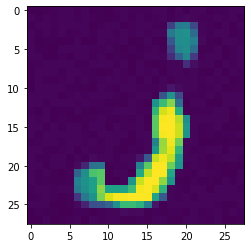

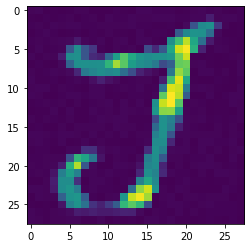

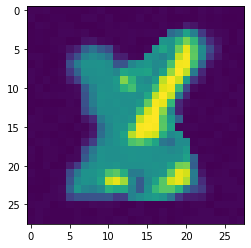

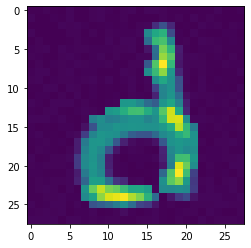

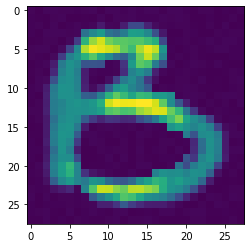

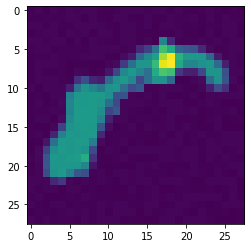

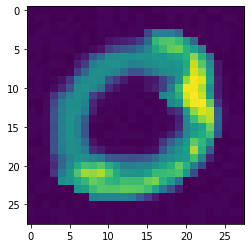

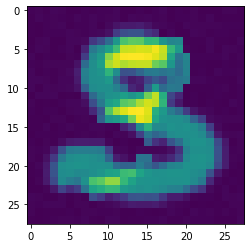

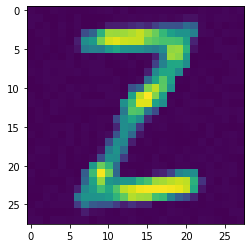

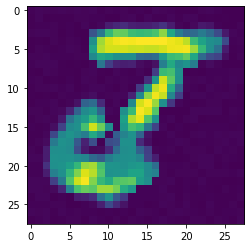

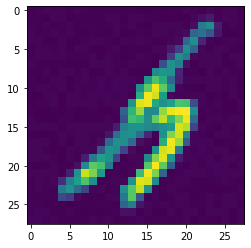

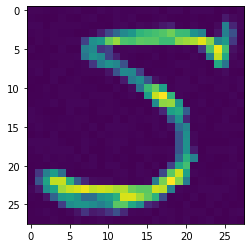

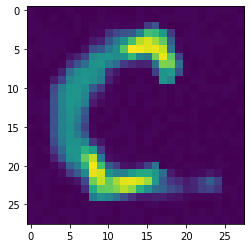

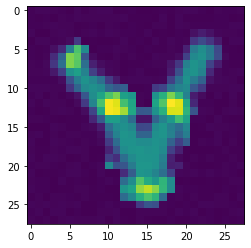

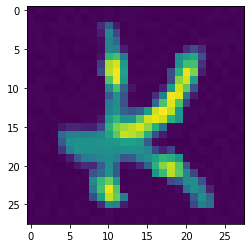

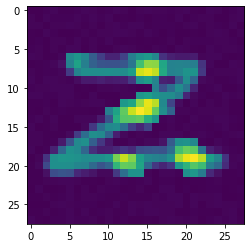

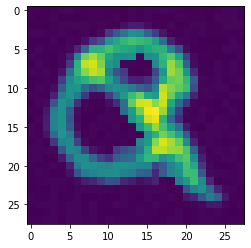

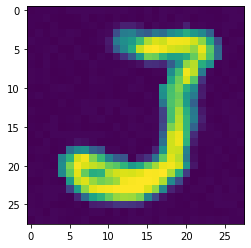

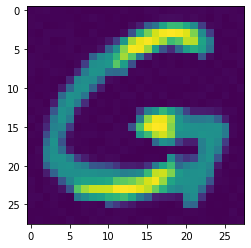

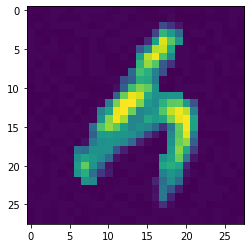

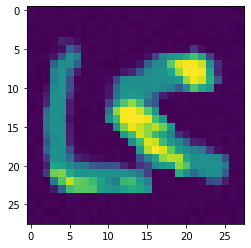

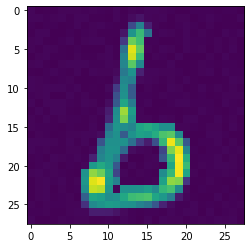

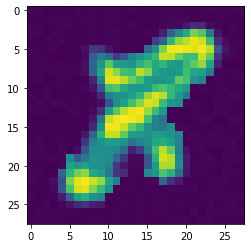

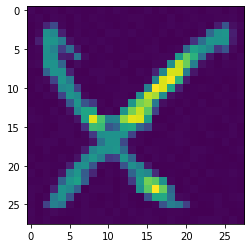

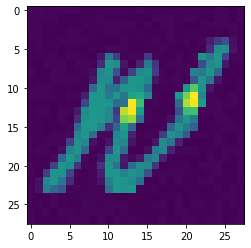

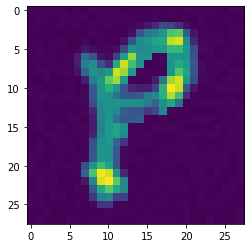

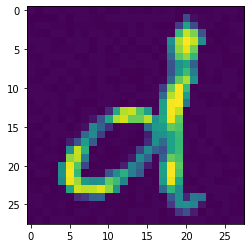

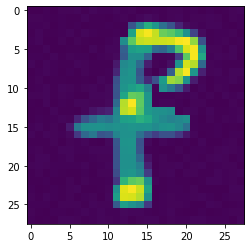

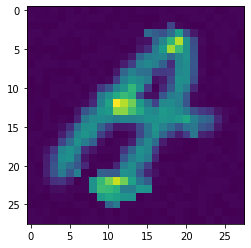

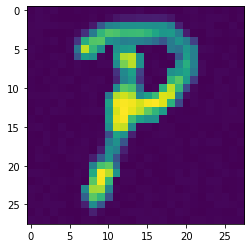

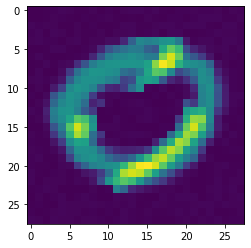

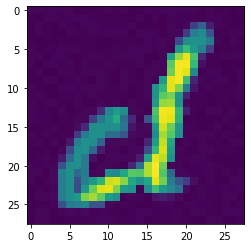

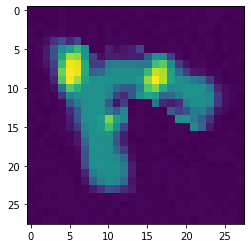

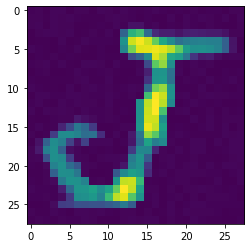

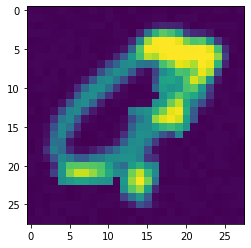

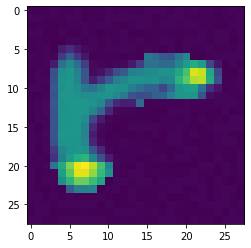

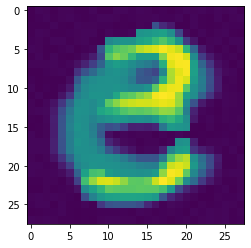

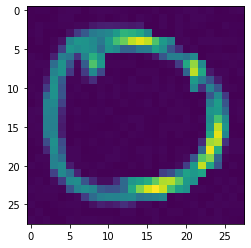

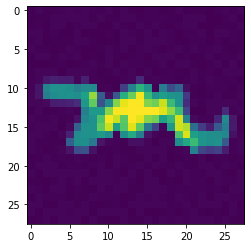

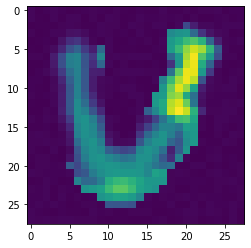

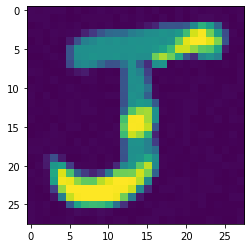

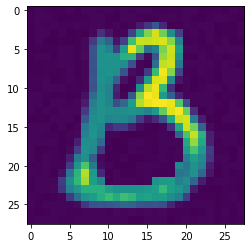

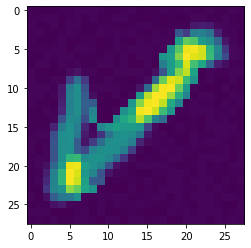

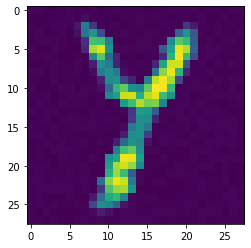

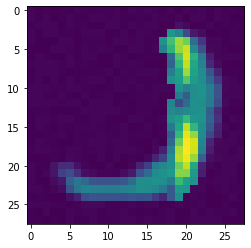

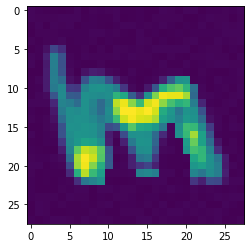

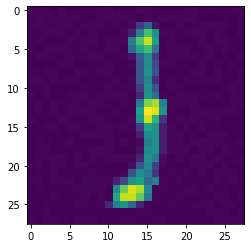

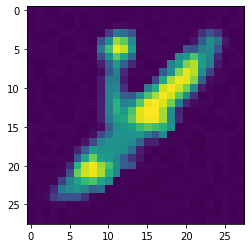

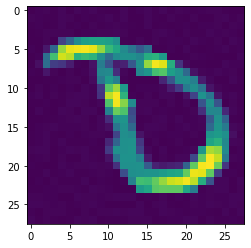

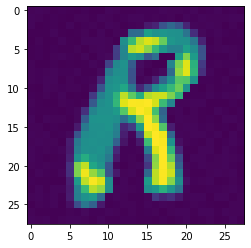

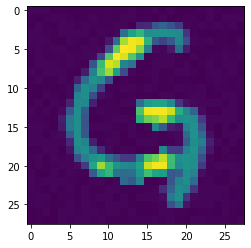

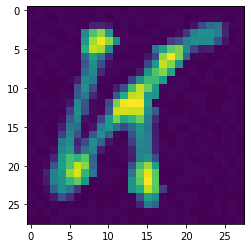

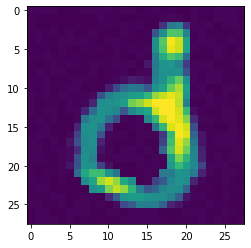

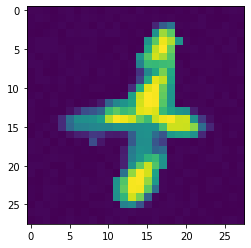

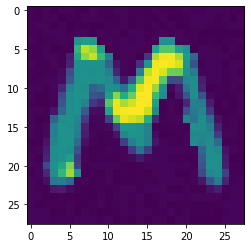

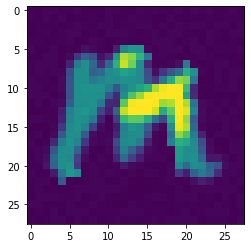

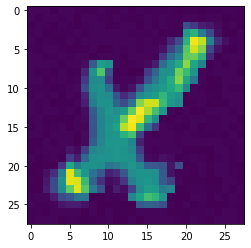

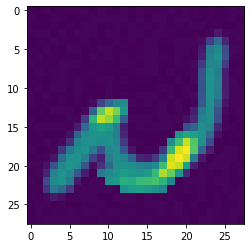

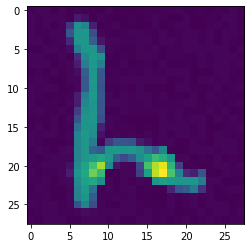

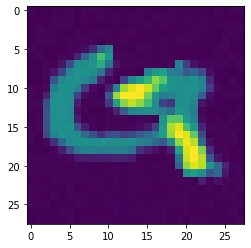

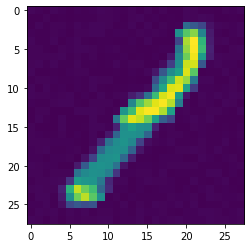

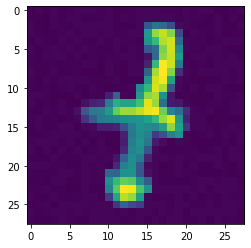

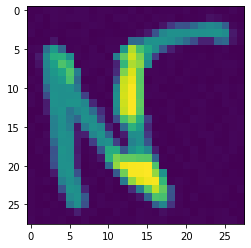

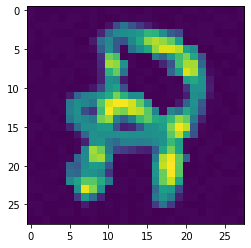

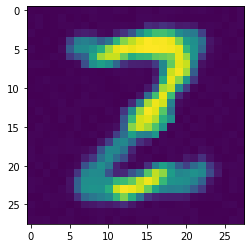

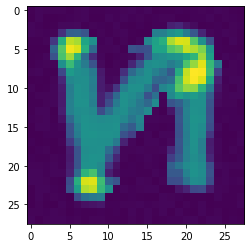

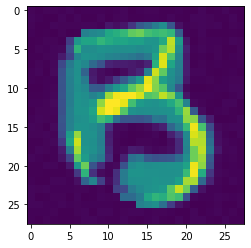

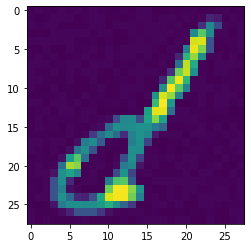

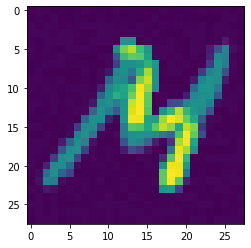

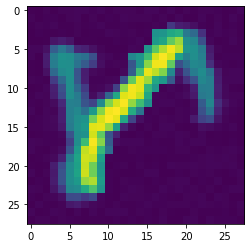

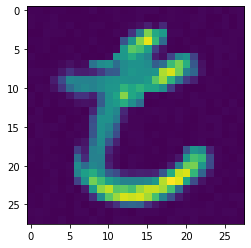

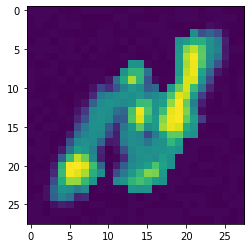

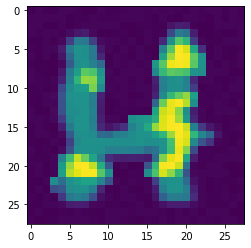

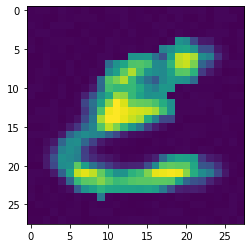

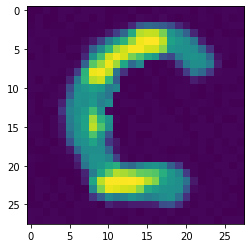

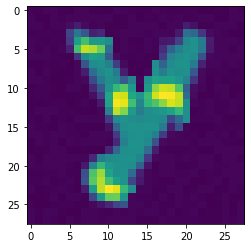

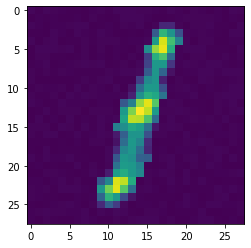

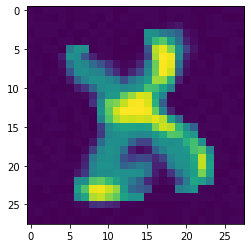

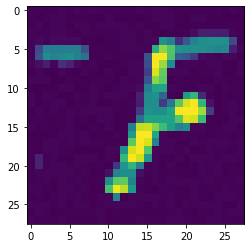

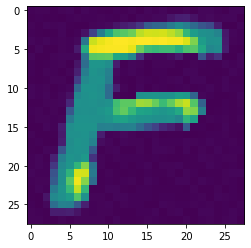

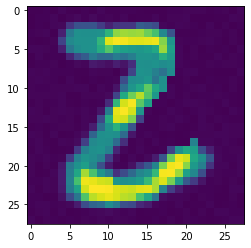

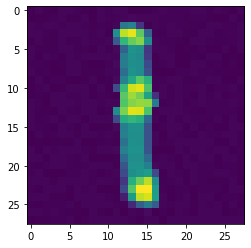

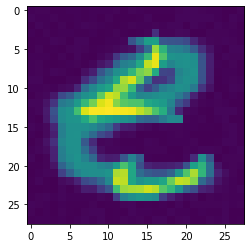

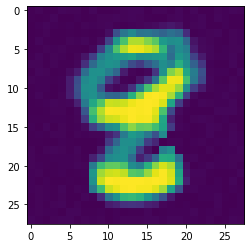

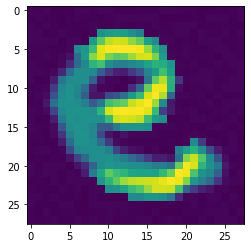

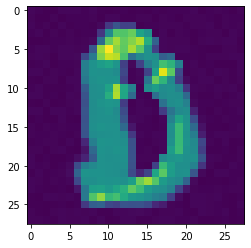

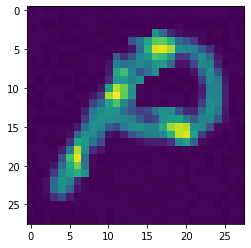

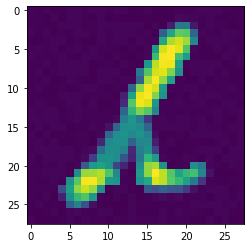

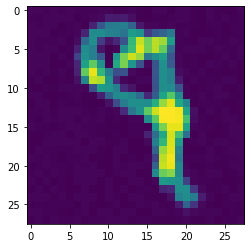

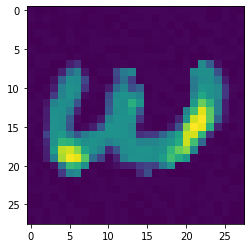

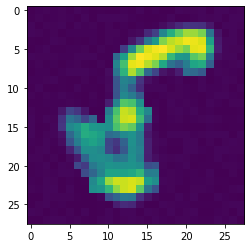

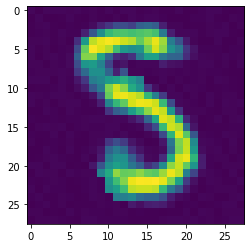

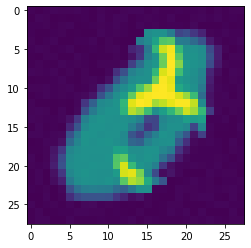

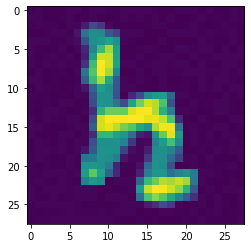

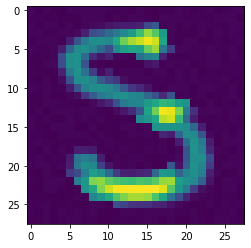

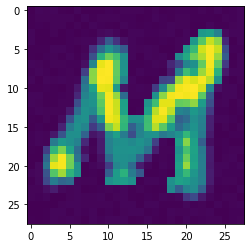

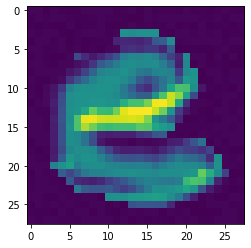

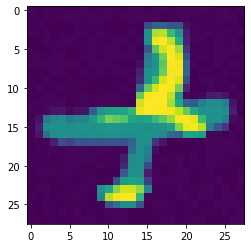

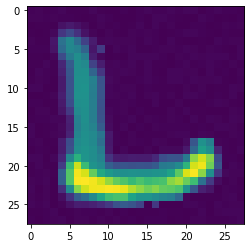

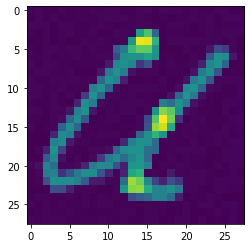

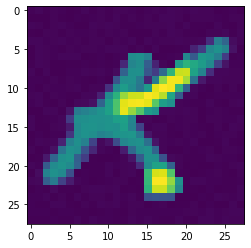

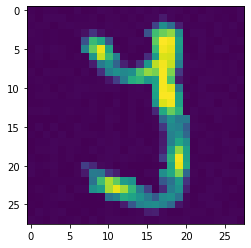

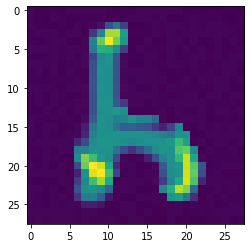

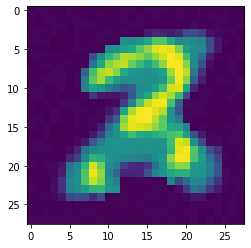

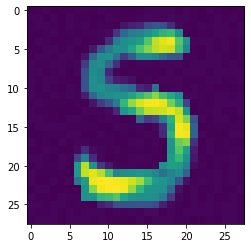

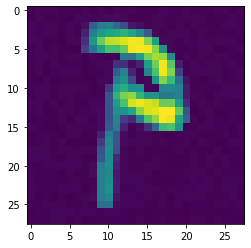

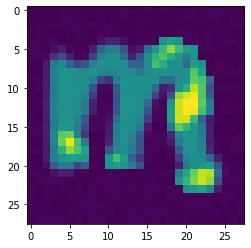

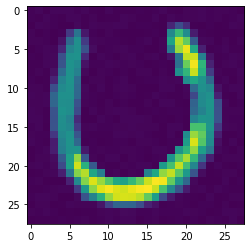

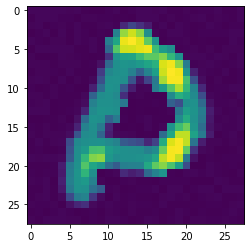

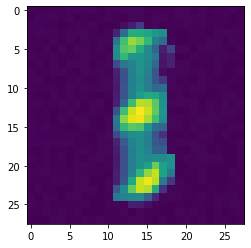

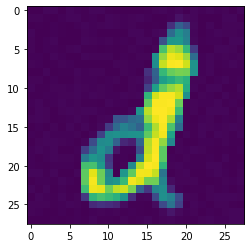

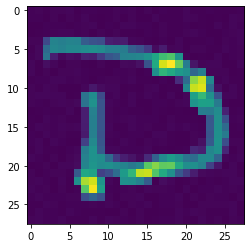

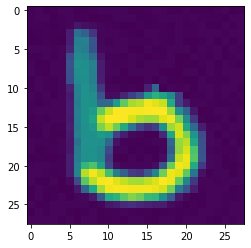

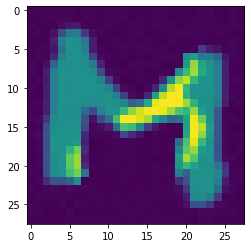

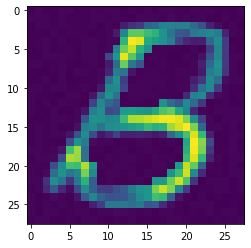

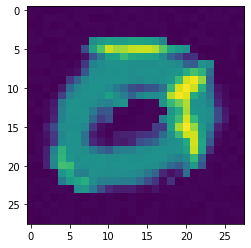

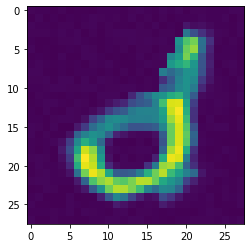

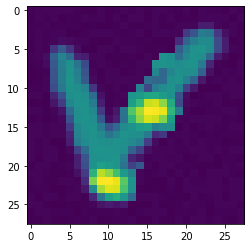

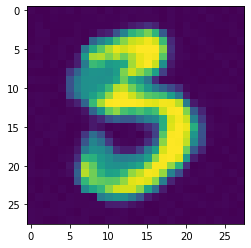

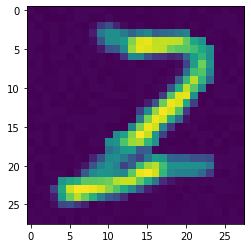

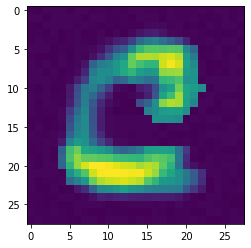

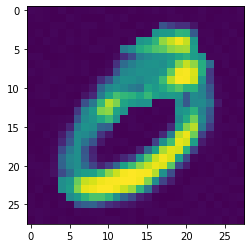

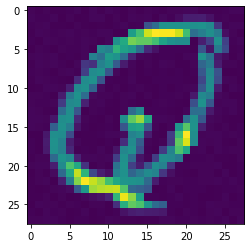

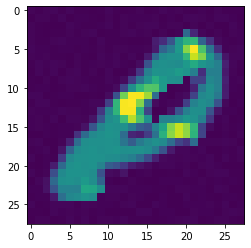

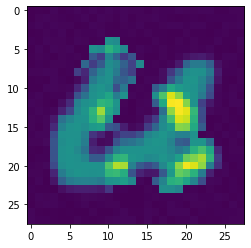

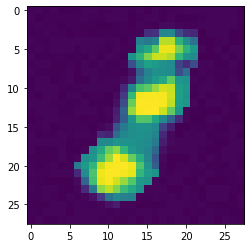

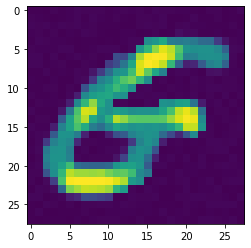

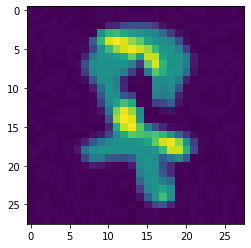

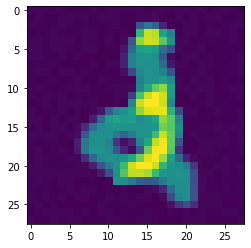

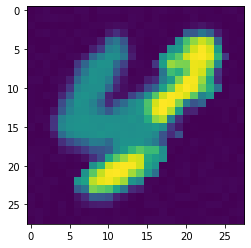

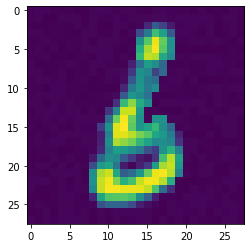

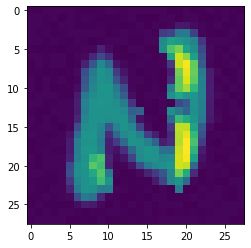

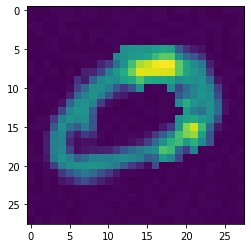

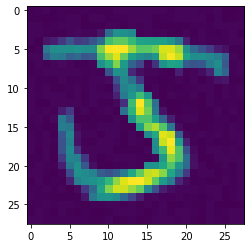

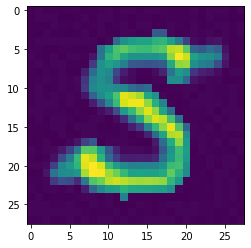

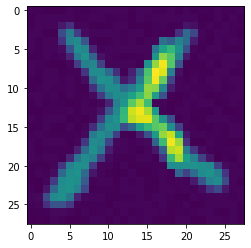

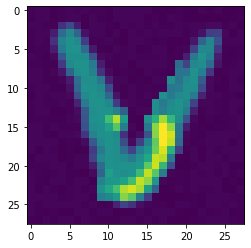

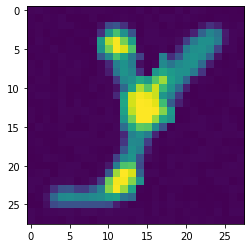

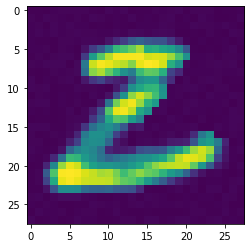

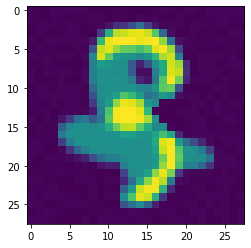

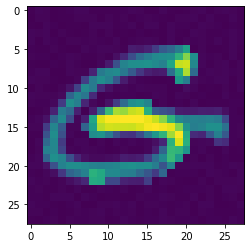

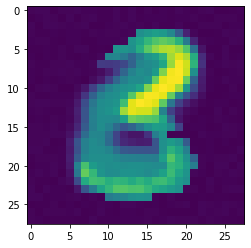

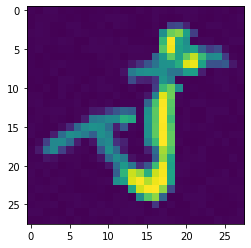

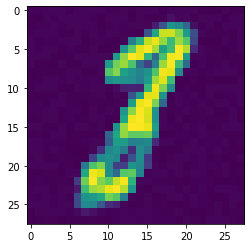

In [13]:
sample = x_train[(train.digit == 3)]
for i, img in enumerate(sample):
    plt.imshow(img[:,:,0])
    plt.show()

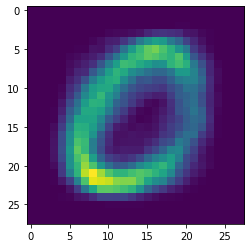

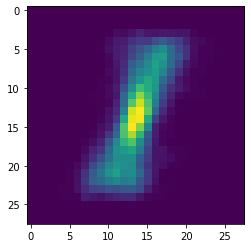

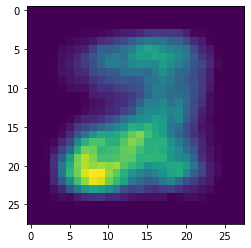

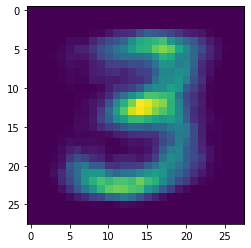

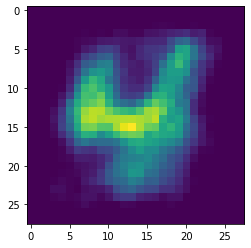

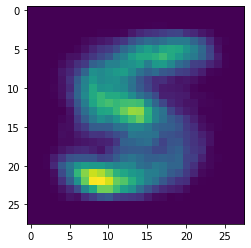

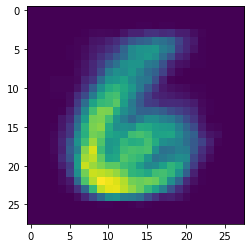

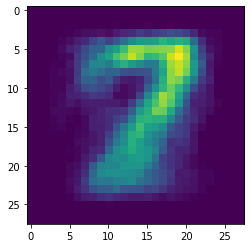

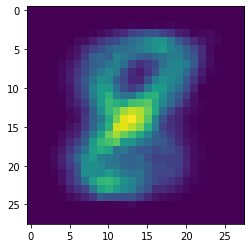

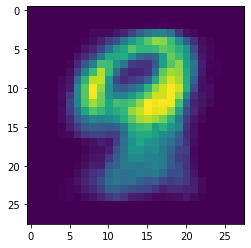

In [41]:
for digit in range(10):
    sample = x_train[(train.digit == digit)]

    img_comb = np.zeros((DIM, DIM))
    for i, img in enumerate(sample):
        img = img[:,:,0]
        img = np.where(img > 2., img, 0)
        img_comb += img
    img_comb /= len(sample)
    plt.imshow(img_comb)
    plt.show()

## STEP 2: Data Augmentation

In [15]:
def rand_bbox(shape, lam):
    
    # CHOOSE RANDOM CENTER
    H, W = shape[:2]
    cx = np.random.randint(H)
    cy = np.random.randint(W)
    
    # CHOOSE RANDOM WIDTH AND HEIGHT
    cut_rate = np.sqrt(1 - lam)
    h = np.int(cut_rate * H)
    w = np.int(cut_rate * W)
    
    xa = np.clip(cx - h//2, 0, H)
    xb = np.clip(cx + h//2, 0, H)
    ya = np.clip(cy - w//2, 0, W)
    yb = np.clip(cy + w//2, 0, W)
    
    return xa, xb, ya, yb

In [42]:
class DataGenerator(tf.keras.utils.Sequence):
    def __init__(
        self, x, y, list_IDs, batch_size=BATCH_SIZE, n_classes=N_CLASSES,
        label=True, augment=False, shuffle=False, cutmix=False, yellow=False
    ):
        self.x = x
        self.y = y
        self.list_IDs = list_IDs
        self.batch_size = batch_size
        self.n_classes = n_classes
        self.augment = augment
        self.label = label
        self.shuffle = shuffle
        self.cutmix = cutmix
        self.yellow = yellow
        self.augs = A.Compose([
            A.OneOf([
                A.ShiftScaleRotate(rotate_limit=8, scale_limit=0.1, shift_limit=0, border_mode=0, value=0, p=0.5),
                A.CoarseDropout(max_holes=8, max_height=DIM//5, max_width=DIM//5, fill_value=0, p=0.5),
            ], p=0.5),
            A.ShiftScaleRotate(rotate_limit=0, scale_limit=0, shift_limit=0.12, border_mode=0, value=0, p=0.5),
        ])
        self.on_epoch_end()
        
    def __len__(self):
        "Number of batches per epoch"
        return math.ceil(len(self.list_IDs) / self.batch_size)
    
    def on_epoch_end(self):
        "Updates indices after each epoch"
        self.indices = np.arange(len(self.list_IDs))
        if self.shuffle:
            np.random.shuffle(self.indices)
            
    def __data_generation(self, list_IDs):
        "Generates data containing `batch_size` samples"
        x = self.x[list_IDs]
        if self.yellow:
            x = np.ones((len(list_IDs), DIM, DIM, 1))
            
        y = np.zeros((len(list_IDs), self.n_classes))
        for i, idx in enumerate(list_IDs):
            y[i, self.y[idx]] = 1
        
        if self.cutmix:
            for i in range(len(list_IDs)):
                
                # PARAMETER FOR CUTMIX
                lam = np.random.beta(1.0, 1.0)
                rand_index = np.random.choice(self.list_IDs)
            
                # CUTMIX IMAGES
                xa, xb, ya, yb = rand_bbox(x[i].shape, lam)                
                x[i,xa:xb,ya:yb,0]  = self.x[rand_index,xa:xb,ya:yb,0]
                
                # CUTMIX LABELS
                lam = 1 - (xb-xa)*(yb-ya)/DIM/DIM
                y2 = np.zeros((1, self.n_classes))
                y2[0, self.y[rand_index]] =1
                y[i] = lam*y[i] + (1-lam)*y2[0]
        
        return x, y
    
    def __getitem__(self, index):
        "Generate one batch of data"
        # Get indices of the batch
        indices = self.indices[index*self.batch_size:(index+1)*self.batch_size]
        
        # Get list of IDs
        list_IDs = self.list_IDs[indices]
        
        # Generate data
        x, y = self.__data_generation(list_IDs)
        
        # Augment data
        if self.augment: 
            x = self.__augment_batch(x)
    
        if self.label:
            return x, y
        else:
            return x
        
    def __augment_batch(self, img_batch):
        for i in range(len(img_batch)):
            img_batch[i] = self.augs(image=img_batch[i])["image"]
        return img_batch

### Data Augmentation - EDA

Cutmix Augmentation with first image displayed in yellow


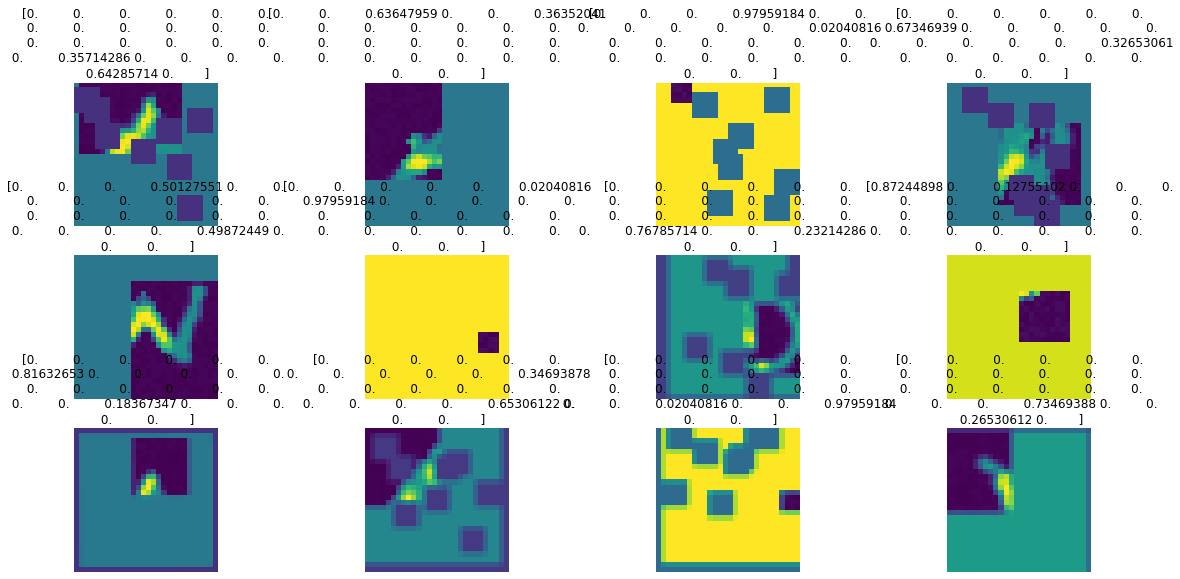

In [43]:
print("Cutmix Augmentation with first image displayed in yellow")
gen = DataGenerator(
    x_train, y_train, np.arange(len(x_train)), batch_size=BATCH_SIZE,
    label=True, augment=True, shuffle=True, cutmix=True, yellow=True,
)

rows = 3; cols = 4
fig, axes = plt.subplots(rows, cols, figsize=(20, (rows/cols)*12))
axes = axes.flatten()
for batch in gen:
    for i, ax in enumerate(axes):
        ax.imshow(batch[0][i,:,:,0])
#         ax.set_title(np.argmax(batch[1][i]))
        ax.set_title(batch[1][i])
        ax.axis("off")
    break

Cutmix Augmentation


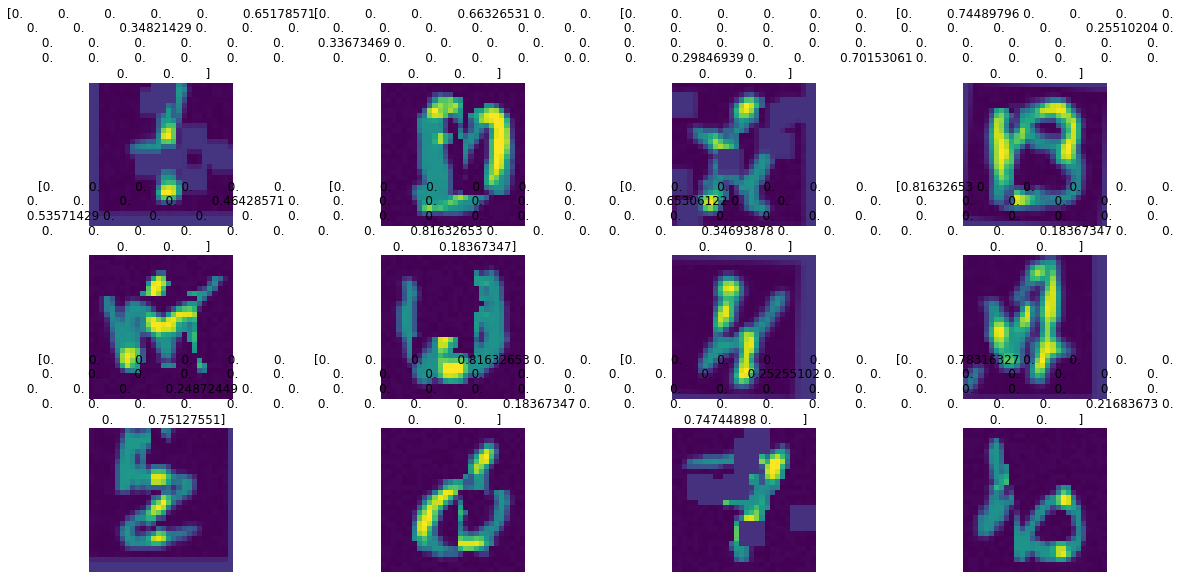

In [44]:
print("Cutmix Augmentation")
gen = DataGenerator(
    x_train, y_train, np.arange(len(x_train)), batch_size=BATCH_SIZE,
    label=True, augment=True, shuffle=True, cutmix=True, yellow=False,
)

rows = 3; cols = 4
fig, axes = plt.subplots(rows, cols, figsize=(20, (rows/cols)*12))
for batch in gen:
    for i, ax in enumerate(axes.flatten()):
        ax.imshow(batch[0][i,:,:,0])
#         ax.set_title(np.argmax(batch[1][i]))
        ax.set_title(batch[1][i])
        ax.axis("off")
    break

## STEP 3: Get Model

In [60]:
def get_vgg(n_classes):
    def two_conv_pool(x, F1, F2, name):
        x = tf.keras.layers.Conv2D(F1, 3, activation="relu", padding='same', name=f'{name}_conv1')(x)
        x = tf.keras.layers.BatchNormalization()(x)
        x = tf.keras.layers.Conv2D(F2, 3, activation="relu", padding='same', name=f'{name}_conv2')(x)
        x = tf.keras.layers.BatchNormalization()(x)
        x = tf.keras.layers.MaxPooling2D(2, 2, name=f'{name}_pool')(x)

        return x

    def three_conv_pool(x, F1, F2, F3, name):
        x = tf.keras.layers.Conv2D(F1, 3, activation="relu", padding='same', name=f'{name}_conv1')(x)
        x = tf.keras.layers.BatchNormalization()(x)
        x = tf.keras.layers.Conv2D(F2, 3, activation="relu", padding='same', name=f'{name}_conv2')(x)
        x = tf.keras.layers.BatchNormalization()(x)
        x = tf.keras.layers.Conv2D(F3, 3, activation="relu", padding='same', name=f'{name}_conv3')(x)
        x = tf.keras.layers.BatchNormalization()(x)
        x = tf.keras.layers.MaxPooling2D(2, strides=2, name=f'{name}_pool')(x)

        return x
    
    inp = tf.keras.Input(shape=(DIM, DIM, 1))
    x = two_conv_pool(inp, 32, 32, "block1")
    x = two_conv_pool(x, 64, 64, "block2")
    x = three_conv_pool(x, 128, 128, 128, "block3")
    x = three_conv_pool(x, 256, 256, 256, "block4")
    x = tf.keras.layers.Flatten(name="features")(x)
    
    x = tf.keras.layers.Dense(512, activation="relu", name="fc-1")(x)
    x = tf.keras.layers.Dense(512, activation="relu", name="fc-2")(x)
    out = tf.keras.layers.Dense(n_classes, activation="softmax", name="out")(x)
    
    model = tf.keras.Model(inp, out)
#     optimizer = tfa.optimizers.RectifiedAdam()
    optimizer = tf.keras.optimizers.Adam()
#     optimizer = tfa.optimizers.SWA(optimizer, start_averaging=20, average_period=10)
    model.compile(loss="categorical_crossentropy", optimizer=optimizer, metrics=["accuracy"])
    
    return model

In [45]:
HALF_WIDTH = 128
LAYER_WIDTH = 128


def get_spinal_vgg(n_classes):
    def two_conv_pool(x, f1, f2, name):
        x = tf.keras.layers.Conv2D(f1, kernel_size=3, activation="relu", padding='same', name=f'{name}_conv1')(x)
        x = tf.keras.layers.BatchNormalization()(x)
        x = tf.keras.layers.Conv2D(f2, kernel_size=3, activation="relu", padding='same', name=f'{name}_conv2')(x)
        x = tf.keras.layers.BatchNormalization()(x)
        x = tf.keras.layers.MaxPooling2D(2, 2, name=f'{name}_pool')(x)

        return x
    
    def three_conv_pool(x, f1, f2, f3, name):
        x = tf.keras.layers.Conv2D(f1, kernel_size=3, activation="relu", padding='same', name=f'{name}_conv1')(x)
        x = tf.keras.layers.BatchNormalization()(x)
        x = tf.keras.layers.Conv2D(f2, kernel_size=3, activation="relu", padding='same', name=f'{name}_conv2')(x)
        x = tf.keras.layers.BatchNormalization()(x)
        x = tf.keras.layers.Conv2D(f3, kernel_size=3, activation="relu", padding='same', name=f'{name}_conv3')(x)
        x = tf.keras.layers.BatchNormalization()(x)
        x = tf.keras.layers.MaxPooling2D(2, strides=2, name=f'{name}_pool')(x)

        return x
        
    def fully_connected(x, name):
        x = tf.keras.layers.Dropout(0.5)(x)
        x = tf.keras.layers.Dense(LAYER_WIDTH, activation="relu", name=name)(x)
        x = tf.keras.layers.BatchNormalization()(x)
        
        return x
    
    
    inp = tf.keras.Input(shape=(DIM, DIM, 1))
    
    # Get VGG-5 features
    x = two_conv_pool(inp, 32, 32, "block1")
    x = two_conv_pool(x, 64, 64, "block2")
    x = three_conv_pool(x, 128, 128, 128, "block3")
    x = three_conv_pool(x, 256, 256, 256, "block4")
    x = tf.keras.layers.Flatten(name="features")(x)
    
    # Fully-connected spinal networks
    x1 = x[:,:HALF_WIDTH]
    x1 = fully_connected(x1, name="spinal-1")
    
    x2 = tf.concat([x[:,HALF_WIDTH:2*HALF_WIDTH], x1], axis=1)
    x2 = fully_connected(x2, name="spinal-2")
    
    x3 = tf.concat([x[:,0:HALF_WIDTH], x2], axis=1)
    x3 = fully_connected(x3, name="spinal-3")
    
    x4 = tf.concat([x[:,HALF_WIDTH:2*HALF_WIDTH], x3], axis=1)
    x4 = fully_connected(x4, name="spinal-4")
    
    x = tf.concat([x1, x2, x3, x4], axis=1, name="features")
    
    x = tf.keras.layers.Dropout(0.5)(x)
    x = tf.keras.layers.Dense(n_classes, activation="softmax")(x)
    
    model = tf.keras.Model(inputs=inp, outputs=x)
    
    optimizer = tf.keras.optimizers.Adam()
    model.compile(loss="categorical_crossentropy", optimizer=optimizer, metrics=["accuracy"])
    
    return model

In [68]:
def get_model():
    inp = tf.keras.Input(shape=(DIM, DIM, 1))
    
    x = tf.keras.layers.Conv2D(128, kernel_size=5, strides=1, padding="same", activation="relu")(inp)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.Conv2D(128, kernel_size=2, strides=1, padding="same", activation="relu")(x)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.MaxPooling2D((2, 2))(x)
    
    x = tf.keras.layers.Conv2D(256, kernel_size=2, strides=1, padding="same", activation="relu")(x)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.Conv2D(256, kernel_size=2, strides=1, padding="same", activation="relu")(x)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.MaxPooling2D((2, 2))(x)
    
#     x = tf.keras.layers.Flatten()(x)
    x = tf.keras.layers.GlobalAveragePooling2D()(x)
    x = tf.keras.layers.Dense(1024, activation="relu")(x)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.Dropout(0.4)(x)
    x = tf.keras.layers.Dense(N_CLASSES, activation="softmax")(x)
    
    
    model = tf.keras.Model(inputs=inp, outputs=x)
    
#     optimizer = tf.keras.optimizers.Adam(lr=1e-5)
    optimizer = tf.keras.optimizers.Adam()
    model.compile(loss="categorical_crossentropy", optimizer=optimizer, metrics=["accuracy"])
    
    return model

In [69]:
from tensorflow.keras.layers import (
    Conv2D, BatchNormalization, Dropout, Flatten, Dense
)

model = tf.keras.Sequential()

model.add(Conv2D(32,kernel_size=3,activation='relu',input_shape=(28,28,1)))
model.add(BatchNormalization())
model.add(Conv2D(32,kernel_size=3,activation='relu'))
model.add(BatchNormalization())
model.add(Conv2D(32,kernel_size=5,strides=2,padding='same',activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.4))

model.add(Conv2D(64,kernel_size=3,activation='relu'))
model.add(BatchNormalization())
model.add(Conv2D(64,kernel_size=3,activation='relu'))
model.add(BatchNormalization())
model.add(Conv2D(64,kernel_size=5,strides=2,padding='same',activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.4))

model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.4))
model.add(Dense(10, activation='softmax'))

model.compile(optimizer="adam", loss="categorical_crossentropy", metrics=["accuracy"])

In [46]:
test = pd.read_csv(DATA_PATH / "test.csv")
x_test = test.drop(["id", "letter"], axis=1).values
x_test = x_test.reshape((-1, DIM, DIM, 1))
x_test = x_test / 255.
x_test = (x_test - MEAN) / STD
print("Test shape", x_test.shape)

Test shape (20480, 28, 28, 1)


In [47]:
y_test = test.letter.map(LETTER_LABEL_MAP).values
print("Test label shape", y_test.shape)

Test label shape (20480,)


In [48]:
train_params = {"n_classes": 26, "label": True, "augment": True, "shuffle": True, "cutmix": False}
valid_params = {"n_classes": 26, "label": True, "augment": False, "shuffle": False, "cutmix": False}
test_params = {"n_classes": 26, "label": False, "augment": False, "shuffle": False, "cutmix": False}

train_idx, valid_idx = model_selection.train_test_split(np.arange(len(y_test)), test_size=0.1, stratify=y_test)

train_gen = DataGenerator(x_test, y_test, train_idx, **train_params)
val_gen = DataGenerator(x_test, y_test, valid_idx, **valid_params)

lr = tf.keras.callbacks.LearningRateScheduler(lambda x: 1e-3 * 0.95 ** x)
es = tf.keras.callbacks.EarlyStopping(monitor="val_accuracy", patience=15, verbose=1, mode="max")

with strategy.scope():
    model = get_spinal_vgg(n_classes=26)

history = model.fit(train_gen, epochs=100, verbose=1, validation_data=val_gen, callbacks=[lr, es])

Epoch 1/100
288/288 [==============================] - 5s 16ms/step - loss: 2.2549 - accuracy: 0.4001 - val_loss: 2.2118 - val_accuracy: 0.3706
Epoch 2/100
288/288 [==============================] - 4s 15ms/step - loss: 0.8822 - accuracy: 0.7287 - val_loss: 0.4257 - val_accuracy: 0.8594
Epoch 3/100
288/288 [==============================] - 4s 16ms/step - loss: 0.6185 - accuracy: 0.8083 - val_loss: 0.3577 - val_accuracy: 0.8931
Epoch 4/100
288/288 [==============================] - 4s 15ms/step - loss: 0.5056 - accuracy: 0.8411 - val_loss: 0.2848 - val_accuracy: 0.9087
Epoch 5/100
288/288 [==============================] - 4s 15ms/step - loss: 0.4380 - accuracy: 0.8600 - val_loss: 0.3020 - val_accuracy: 0.8989
Epoch 6/100
288/288 [==============================] - 4s 15ms/step - loss: 0.3779 - accuracy: 0.8785 - val_loss: 0.2456 - val_accuracy: 0.9165
Epoch 7/100
288/288 [==============================] - 4s 15ms/step - loss: 0.3550 - accuracy: 0.8855 - val_loss: 0.2024 - val_accuracy:

In [49]:
with strategy.scope():
    pretrained_model = tf.keras.Sequential()
    pretrained_model.add(tf.keras.Model(inputs=model.input, outputs=model.get_layer("features").output))
    pretrained_model.add(tf.keras.layers.Dropout(0.5))
    pretrained_model.add(tf.keras.layers.Dense(10, activation="softmax"))
    
    pretrained_model.compile(loss="categorical_crossentropy", optimizer="adam", metrics=["accuracy"])

In [63]:
train_params = {"n_classes": 10, "label": True, "augment": True, "shuffle": True, "cutmix": False}
valid_params = {"n_classes": 10, "label": True, "augment": False, "shuffle": False, "cutmix": False}
test_params = {"n_classes": 10, "label": False, "augment": False, "shuffle": False, "cutmix": False}

y_train = train.digit.values
train_idx, valid_idx = model_selection.train_test_split(np.arange(len(x_train)), test_size=0.1)

train_gen = DataGenerator(x_train, y_train, train_idx, **train_params)
val_gen = DataGenerator(x_train, y_train, valid_idx, **valid_params)

es = tf.keras.callbacks.EarlyStopping(monitor="val_accuracy", patience=10, verbose=1, mode="max", restore_best_weights=True)
lr = tf.keras.callbacks.ReduceLROnPlateau(monitor="val_accuracy", factor=0.5, patience=15, verbose=1, mode="max")

with strategy.scope():
    model = get_vgg(n_classes=10)
history = model.fit(
    train_gen, epochs=100, verbose=1, validation_data=val_gen, callbacks=[es, lr]
)

# history = pretrained_model.fit(
#     train_gen, epochs=100, verbose=1, validation_data=val_gen, callbacks=[es]
# )

Epoch 1/100
29/29 [==============================] - 1s 20ms/step - loss: 2.3226 - accuracy: 0.1796 - val_loss: 2.3182 - val_accuracy: 0.1024
Epoch 2/100
29/29 [==============================] - 0s 15ms/step - loss: 1.8689 - accuracy: 0.3256 - val_loss: 2.3474 - val_accuracy: 0.0829
Epoch 3/100
29/29 [==============================] - 0s 15ms/step - loss: 1.6085 - accuracy: 0.4265 - val_loss: 2.4970 - val_accuracy: 0.0878
Epoch 4/100
29/29 [==============================] - 0s 15ms/step - loss: 1.3292 - accuracy: 0.5285 - val_loss: 2.3974 - val_accuracy: 0.0829
Epoch 5/100
29/29 [==============================] - 0s 14ms/step - loss: 1.1993 - accuracy: 0.5871 - val_loss: 3.3266 - val_accuracy: 0.0829
Epoch 6/100
29/29 [==============================] - 0s 15ms/step - loss: 1.1030 - accuracy: 0.6256 - val_loss: 3.2098 - val_accuracy: 0.1561
Epoch 7/100
29/29 [==============================] - 0s 15ms/step - loss: 0.9697 - accuracy: 0.6603 - val_loss: 3.0128 - val_accuracy: 0.1512
Epoch 

In [58]:
gc.collect()
K.clear_session()

In [ ]:
oof = np.zeros((len(x_train), N_CLASSES))

kf = model_selection.StratifiedKFold(n_splits=5, shuffle=True)
from fold, (train_idx, valid_idx) in enumerate(sk.split(x_train, y_train)):
    K.clear_session()
    with strategy.scope():
        model = get_vgg(n_classes=10)
        
    train_gen = DataGenerator(x_train, y_train, train_idx, shuffle=True, augment=True)

## STEP 4: Training Schedule

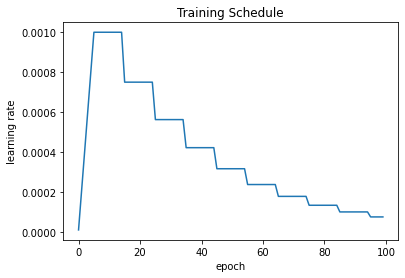

In [54]:
# CUSTOM LEARNING RATE SCHEDULE
LR_START = 1e-5
LR_MAX = 1e-3
LR_RAMUP_EPOCHS = 5
LR_SUSTAIN_EPOCHS = 0
LR_STEP_DECAY = 0.75

def lrfn(epoch):
    if epoch < LR_RAMUP_EPOCHS:
        lr = (LR_MAX - LR_START) / LR_RAMUP_EPOCHS * epoch + LR_START
    elif epoch < LR_RAMUP_EPOCHS + LR_SUSTAIN_EPOCHS:
        lr = LR_MAX
    else:
        lr = LR_MAX * LR_STEP_DECAY ** ((epoch - LR_RAMUP_EPOCHS - LR_SUSTAIN_EPOCHS)//10)
    return lr

lr_callback = tf.keras.callbacks.LearningRateScheduler(lrfn, verbose=True)

rng = np.arange(EPOCHS)
y = [lrfn(x) for x in rng]
plt.plot(rng, y)
plt.xlabel("epoch"); plt.ylabel("learning rate")
plt.title("Training Schedule");

In [93]:
gc.collect()

25198

In [94]:
train.head()

,id,digit,letter,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80,81,82,83,84,85,86,87,88,89,90,91,92,93,94,95,96,97,98,99,100,101,102,103,104,105,106,107,108,109,110,111,112,113,114,115,116,117,118,119,120,121,122,123,124,125,126,127,128,129,130,131,132,133,134,135,136,137,138,139,140,141,142,143,144,145,146,147,148,149,150,151,152,153,154,155,156,157,158,159,160,161,162,163,164,165,166,167,168,169,170,171,172,173,174,175,176,177,178,179,180,181,182,183,184,185,186,187,188,189,190,191,192,193,194,195,196,197,198,199,200,201,202,203,204,205,206,207,208,209,210,211,212,213,214,215,216,217,218,219,220,221,222,223,224,225,226,227,228,229,230,231,232,233,234,235,236,237,238,239,240,241,242,243,244,245,246,247,248,249,250,251,252,253,254,255,256,257,258,259,260,261,262,263,264,265,266,267,268,269,270,271,272,273,274,275,276,277,278,279,280,281,282,283,284,285,286,287,288,289,290,291,292,293,294,295,296,297,298,299,300,301,302,303,304,305,306,307,308,309,310,311,312,313,314,315,316,317,318,319,320,321,322,323,324,325,326,327,328,329,330,331,332,333,334,335,336,337,338,339,340,341,342,343,344,345,346,347,348,349,350,351,352,353,354,355,356,357,358,359,360,361,362,363,364,365,366,367,368,369,370,371,372,373,374,375,376,377,378,379,380,381,382,383,384,385,386,387,388,389,390,391,392,393,394,395,396,397,398,399,400,401,402,403,404,405,406,407,408,409,410,411,412,413,414,415,416,417,418,419,420,421,422,423,424,425,426,427,428,429,430,431,432,433,434,435,436,437,438,439,440,441,442,443,444,445,446,447,448,449,450,451,452,453,454,455,456,457,458,459,460,461,462,463,464,465,466,467,468,469,470,471,472,473,474,475,476,477,478,479,480,481,482,483,484,485,486,487,488,489,490,491,492,493,494,495,496,497,498,499,500,501,502,503,504,505,506,507,508,509,510,511,512,513,514,515,516,517,518,519,520,521,522,523,524,525,526,527,528,529,530,531,532,533,534,535,536,537,538,539,540,541,542,543,544,545,546,547,548,549,550,551,552,553,554,555,556,557,558,559,560,561,562,563,564,565,566,567,568,569,570,571,572,573,574,575,576,577,578,579,580,581,582,583,584,585,586,587,588,589,590,591,592,593,594,595,596,597,598,599,600,601,602,603,604,605,606,607,608,609,610,611,612,613,614,615,616,617,618,619,620,621,622,623,624,625,626,627,628,629,630,631,632,633,634,635,636,637,638,639,640,641,642,643,644,645,646,647,648,649,650,651,652,653,654,655,656,657,658,659,660,661,662,663,664,665,666,667,668,669,670,671,672,673,674,675,676,677,678,679,680,681,682,683,684,685,686,687,688,689,690,691,692,693,694,695,696,697,698,699,700,701,702,703,704,705,706,707,708,709,710,711,712,713,714,715,716,717,718,719,720,721,722,723,724,725,726,727,728,729,730,731,732,733,734,735,736,737,738,739,740,741,742,743,744,745,746,747,748,749,750,751,752,753,754,755,756,757,758,759,760,761,762,763,764,765,766,767,768,769,770,771,772,773,774,775,776,777,778,779,780,781,782,783
0,1,5,L,1,1,1,4,3,0,0,4,4,3,0,4,3,3,3,4,4,0,0,1,1,3,4,0,4,2,0,4,0,1,3,1,0,4,1,1,3,1,2,4,2,4,3,1,0,1,2,3,0,3,3,1,3,4,1,3,2,0,4,4,2,3,2,3,0,0,4,0,2,16,73,51,21,1,2,1,4,3,3,2,1,3,3,3,0,2,4,1,0,0,0,0,1,0,0,3,108,176,249,190,128,3,0,3,1,1,4,0,4,3,3,3,3,0,0,4,2,3,1,4,4,3,3,4,133,188,207,107,96,1,1,1,2,4,3,3,1,3,3,1,3,1,3,3,1,1,2,2,4,1,0,1,119,137,133,28,0,4,3,1,3,2,4,1,1,2,3,3,4,2,3,4,4,4,2,1,1,2,4,3,0,31,123,62,5,3,3,2,4,3,2,2,1,3,0,3,1,4,4,3,2,4,4,3,1,3,0,4,5,46,126,66,3,3,3,1,4,0,1,4,4,1,1,3,4,4,1,3,2,0,3,0,3,2,0,4,6,65,127,67,6,0,2,3,1,1,1,4,4,4,4,3,1,2,1,2,0,1,1,3,2,3,0,1,4,66,120,44,3,2,0,1,3,4,4,3,1,2,0,3,0,3,4,3,2,0,0,4,4,3,2,1,22,106,112,22,4,2,2,0,1,1,4,3,3,3,0,2,3,4,3,2,2,3,2,4,2,3,0,3,102,130,114,19,3,0,1,3,1,1,0,1,0,0,2,4,4,3,2,0,0,1,0,2,3,3,1,1,143,200,150,24,4,4,4,4,4,4,2,1,2,0,2,3,3,0,0,1,2,1,0,4,3,2,0,10,128,240,220,66,4,4,2,2,1,3,0,2,2,4,2,2,3,2,1,0,4,4,4,3,1,2,4,6,67,166,217,142,0,3,0,1,2,3,4,2,2,2,1,0,3,0,0,1,2,1,2,0,1,0,3,6,66,1

In [95]:
test.head()

,id,letter,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80,81,82,83,84,85,86,87,88,89,90,91,92,93,94,95,96,97,98,99,100,101,102,103,104,105,106,107,108,109,110,111,112,113,114,115,116,117,118,119,120,121,122,123,124,125,126,127,128,129,130,131,132,133,134,135,136,137,138,139,140,141,142,143,144,145,146,147,148,149,150,151,152,153,154,155,156,157,158,159,160,161,162,163,164,165,166,167,168,169,170,171,172,173,174,175,176,177,178,179,180,181,182,183,184,185,186,187,188,189,190,191,192,193,194,195,196,197,198,199,200,201,202,203,204,205,206,207,208,209,210,211,212,213,214,215,216,217,218,219,220,221,222,223,224,225,226,227,228,229,230,231,232,233,234,235,236,237,238,239,240,241,242,243,244,245,246,247,248,249,250,251,252,253,254,255,256,257,258,259,260,261,262,263,264,265,266,267,268,269,270,271,272,273,274,275,276,277,278,279,280,281,282,283,284,285,286,287,288,289,290,291,292,293,294,295,296,297,298,299,300,301,302,303,304,305,306,307,308,309,310,311,312,313,314,315,316,317,318,319,320,321,322,323,324,325,326,327,328,329,330,331,332,333,334,335,336,337,338,339,340,341,342,343,344,345,346,347,348,349,350,351,352,353,354,355,356,357,358,359,360,361,362,363,364,365,366,367,368,369,370,371,372,373,374,375,376,377,378,379,380,381,382,383,384,385,386,387,388,389,390,391,392,393,394,395,396,397,398,399,400,401,402,403,404,405,406,407,408,409,410,411,412,413,414,415,416,417,418,419,420,421,422,423,424,425,426,427,428,429,430,431,432,433,434,435,436,437,438,439,440,441,442,443,444,445,446,447,448,449,450,451,452,453,454,455,456,457,458,459,460,461,462,463,464,465,466,467,468,469,470,471,472,473,474,475,476,477,478,479,480,481,482,483,484,485,486,487,488,489,490,491,492,493,494,495,496,497,498,499,500,501,502,503,504,505,506,507,508,509,510,511,512,513,514,515,516,517,518,519,520,521,522,523,524,525,526,527,528,529,530,531,532,533,534,535,536,537,538,539,540,541,542,543,544,545,546,547,548,549,550,551,552,553,554,555,556,557,558,559,560,561,562,563,564,565,566,567,568,569,570,571,572,573,574,575,576,577,578,579,580,581,582,583,584,585,586,587,588,589,590,591,592,593,594,595,596,597,598,599,600,601,602,603,604,605,606,607,608,609,610,611,612,613,614,615,616,617,618,619,620,621,622,623,624,625,626,627,628,629,630,631,632,633,634,635,636,637,638,639,640,641,642,643,644,645,646,647,648,649,650,651,652,653,654,655,656,657,658,659,660,661,662,663,664,665,666,667,668,669,670,671,672,673,674,675,676,677,678,679,680,681,682,683,684,685,686,687,688,689,690,691,692,693,694,695,696,697,698,699,700,701,702,703,704,705,706,707,708,709,710,711,712,713,714,715,716,717,718,719,720,721,722,723,724,725,726,727,728,729,730,731,732,733,734,735,736,737,738,739,740,741,742,743,744,745,746,747,748,749,750,751,752,753,754,755,756,757,758,759,760,761,762,763,764,765,766,767,768,769,770,771,772,773,774,775,776,777,778,779,780,781,782,783
0,2049,L,0,4,0,2,4,2,3,1,0,0,1,0,1,3,4,4,0,0,2,4,4,1,3,3,2,2,4,1,0,1,2,2,1,2,2,1,4,0,4,4,3,1,3,2,2,2,0,1,4,4,4,1,2,4,0,2,1,2,4,1,1,3,1,2,3,0,3,2,4,4,2,33,70,35,4,3,3,3,2,3,0,2,4,0,2,0,2,1,4,2,4,4,0,4,4,2,4,1,44,165,216,84,2,2,3,4,1,0,4,2,2,4,3,4,4,1,0,3,2,3,3,4,2,1,0,19,110,230,247,118,6,2,1,3,1,3,1,2,0,1,3,2,3,1,2,1,4,4,0,2,1,2,0,64,175,252,230,86,6,4,4,2,0,2,1,3,3,0,0,4,4,4,4,0,1,4,4,1,2,0,2,128,193,245,175,69,6,2,0,3,3,0,4,4,2,3,2,2,4,1,0,3,1,0,1,3,4,1,4,146,192,227,144,64,3,4,3,0,1,3,4,2,2,2,2,2,0,0,2,1,1,2,0,2,3,4,1,146,176,174,130,66,6,2,3,2,4,0,1,1,2,2,1,4,1,1,3,4,0,1,0,3,4,4,0,142,131,130,127,67,2,1,1,3,3,1,0,0,2,3,3,3,1,2,4,1,1,2,0,4,0,3,112,106,114,129,118,42,5,3,3,0,0,4,0,4,4,0,2,0,0,3,1,2,4,1,3,2,3,2,55,90,120,127,109,23,3,1,3,4,2,2,2,3,0,1,4,4,1,3,0,2,0,1,3,2,3,4,32,114,129,130,89,15,1,4,2,0,0,3,3,3,0,1,3,0,4,4,0,3,2,1,2,4,1,14,61,126,137,144,101,73,4,1,4,0,2,1,1,0,4,0,3,0,2,3,4,4,4,0,4,2,1,10,81,153,206,222,141,3,4,0,4,0,0,0,3,0,2,3,1,

In [96]:
test.digit = -1
all_images = pd.concat([train, test])
all_images.head()

,id,digit,letter,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80,81,82,83,84,85,86,87,88,89,90,91,92,93,94,95,96,97,98,99,100,101,102,103,104,105,106,107,108,109,110,111,112,113,114,115,116,117,118,119,120,121,122,123,124,125,126,127,128,129,130,131,132,133,134,135,136,137,138,139,140,141,142,143,144,145,146,147,148,149,150,151,152,153,154,155,156,157,158,159,160,161,162,163,164,165,166,167,168,169,170,171,172,173,174,175,176,177,178,179,180,181,182,183,184,185,186,187,188,189,190,191,192,193,194,195,196,197,198,199,200,201,202,203,204,205,206,207,208,209,210,211,212,213,214,215,216,217,218,219,220,221,222,223,224,225,226,227,228,229,230,231,232,233,234,235,236,237,238,239,240,241,242,243,244,245,246,247,248,249,250,251,252,253,254,255,256,257,258,259,260,261,262,263,264,265,266,267,268,269,270,271,272,273,274,275,276,277,278,279,280,281,282,283,284,285,286,287,288,289,290,291,292,293,294,295,296,297,298,299,300,301,302,303,304,305,306,307,308,309,310,311,312,313,314,315,316,317,318,319,320,321,322,323,324,325,326,327,328,329,330,331,332,333,334,335,336,337,338,339,340,341,342,343,344,345,346,347,348,349,350,351,352,353,354,355,356,357,358,359,360,361,362,363,364,365,366,367,368,369,370,371,372,373,374,375,376,377,378,379,380,381,382,383,384,385,386,387,388,389,390,391,392,393,394,395,396,397,398,399,400,401,402,403,404,405,406,407,408,409,410,411,412,413,414,415,416,417,418,419,420,421,422,423,424,425,426,427,428,429,430,431,432,433,434,435,436,437,438,439,440,441,442,443,444,445,446,447,448,449,450,451,452,453,454,455,456,457,458,459,460,461,462,463,464,465,466,467,468,469,470,471,472,473,474,475,476,477,478,479,480,481,482,483,484,485,486,487,488,489,490,491,492,493,494,495,496,497,498,499,500,501,502,503,504,505,506,507,508,509,510,511,512,513,514,515,516,517,518,519,520,521,522,523,524,525,526,527,528,529,530,531,532,533,534,535,536,537,538,539,540,541,542,543,544,545,546,547,548,549,550,551,552,553,554,555,556,557,558,559,560,561,562,563,564,565,566,567,568,569,570,571,572,573,574,575,576,577,578,579,580,581,582,583,584,585,586,587,588,589,590,591,592,593,594,595,596,597,598,599,600,601,602,603,604,605,606,607,608,609,610,611,612,613,614,615,616,617,618,619,620,621,622,623,624,625,626,627,628,629,630,631,632,633,634,635,636,637,638,639,640,641,642,643,644,645,646,647,648,649,650,651,652,653,654,655,656,657,658,659,660,661,662,663,664,665,666,667,668,669,670,671,672,673,674,675,676,677,678,679,680,681,682,683,684,685,686,687,688,689,690,691,692,693,694,695,696,697,698,699,700,701,702,703,704,705,706,707,708,709,710,711,712,713,714,715,716,717,718,719,720,721,722,723,724,725,726,727,728,729,730,731,732,733,734,735,736,737,738,739,740,741,742,743,744,745,746,747,748,749,750,751,752,753,754,755,756,757,758,759,760,761,762,763,764,765,766,767,768,769,770,771,772,773,774,775,776,777,778,779,780,781,782,783
0,1,5.0,L,1,1,1,4,3,0,0,4,4,3,0,4,3,3,3,4,4,0,0,1,1,3,4,0,4,2,0,4,0,1,3,1,0,4,1,1,3,1,2,4,2,4,3,1,0,1,2,3,0,3,3,1,3,4,1,3,2,0,4,4,2,3,2,3,0,0,4,0,2,16,73,51,21,1,2,1,4,3,3,2,1,3,3,3,0,2,4,1,0,0,0,0,1,0,0,3,108,176,249,190,128,3,0,3,1,1,4,0,4,3,3,3,3,0,0,4,2,3,1,4,4,3,3,4,133,188,207,107,96,1,1,1,2,4,3,3,1,3,3,1,3,1,3,3,1,1,2,2,4,1,0,1,119,137,133,28,0,4,3,1,3,2,4,1,1,2,3,3,4,2,3,4,4,4,2,1,1,2,4,3,0,31,123,62,5,3,3,2,4,3,2,2,1,3,0,3,1,4,4,3,2,4,4,3,1,3,0,4,5,46,126,66,3,3,3,1,4,0,1,4,4,1,1,3,4,4,1,3,2,0,3,0,3,2,0,4,6,65,127,67,6,0,2,3,1,1,1,4,4,4,4,3,1,2,1,2,0,1,1,3,2,3,0,1,4,66,120,44,3,2,0,1,3,4,4,3,1,2,0,3,0,3,4,3,2,0,0,4,4,3,2,1,22,106,112,22,4,2,2,0,1,1,4,3,3,3,0,2,3,4,3,2,2,3,2,4,2,3,0,3,102,130,114,19,3,0,1,3,1,1,0,1,0,0,2,4,4,3,2,0,0,1,0,2,3,3,1,1,143,200,150,24,4,4,4,4,4,4,2,1,2,0,2,3,3,0,0,1,2,1,0,4,3,2,0,10,128,240,220,66,4,4,2,2,1,3,0,2,2,4,2,2,3,2,1,0,4,4,4,3,1,2,4,6,67,166,217,142,0,3,0,1,2,3,4,2,2,2,1,0,3,0,0,1,2,1,2,0,1,0,3,6,66

In [97]:
all_images = all_images.iloc[:,3:].values

In [98]:
all_images.shape

(22528, 784)

In [102]:
all_images = all_images.reshape((-1, DIM, DIM, 1))
all_images = all_images.astype(np.float)
all_images /= 255.
mean = np.mean(all_images)
std = np.std(all_images)
mean, std

(0.14273226180564572, 0.25355888286975614)